In [57]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold

from zoopt import Dimension, Objective, Parameter, Opt


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [58]:
print(tf.__version__)

2.11.0


In [59]:
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [60]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [61]:
# change label names to its original names
def change_label_names(df, column_name):
    index = {'normal': 'Normal', 'bact_pneumo': 'Bacterial_Pneumonia', 'viral_pneumo': 'Virus_Pneumonia'}


    df[column_name] = df[column_name].replace(index)

In [62]:
# loading the data
data_dir = '/home/dell/Desktop/rk/chest_xray'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

,filepaths,labels
0,/home/dell/Desktop/rk/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
1,/home/dell/Desktop/rk/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
2,/home/dell/Desktop/rk/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
3,/home/dell/Desktop/rk/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
4,/home/dell/Desktop/rk/chest_xray/bact_pneumo/p...,Bacterial_Pneumonia
...,...,...
5851,/home/dell/Desktop/rk/chest_xray/viral_pneumo/...,Virus_Pneumonia
5852,/home/dell/Desktop/rk/chest_xray/viral_pneumo/...,Virus_Pneumonia
5853,/home/dell/Desktop/rk/chest_xray/viral_pneumo/...,Virus_Pneumonia
5854,/home/dell/Desktop/rk/chest_xray/viral_pneumo/...,Virus_Pneumonia


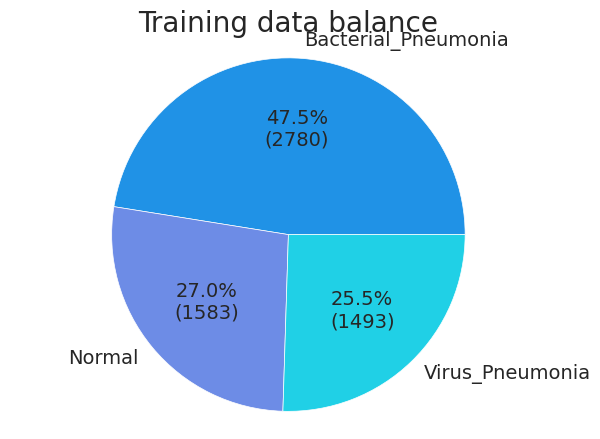

In [63]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [64]:
#spliting the data 
# data --> 80% train data && 20% (test, val)
#train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
#valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [65]:
#kfold cross validation
k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]


    train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)


In [66]:
# create data generators
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4684 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.


Found 586 validated image filenames belonging to 3 classes.


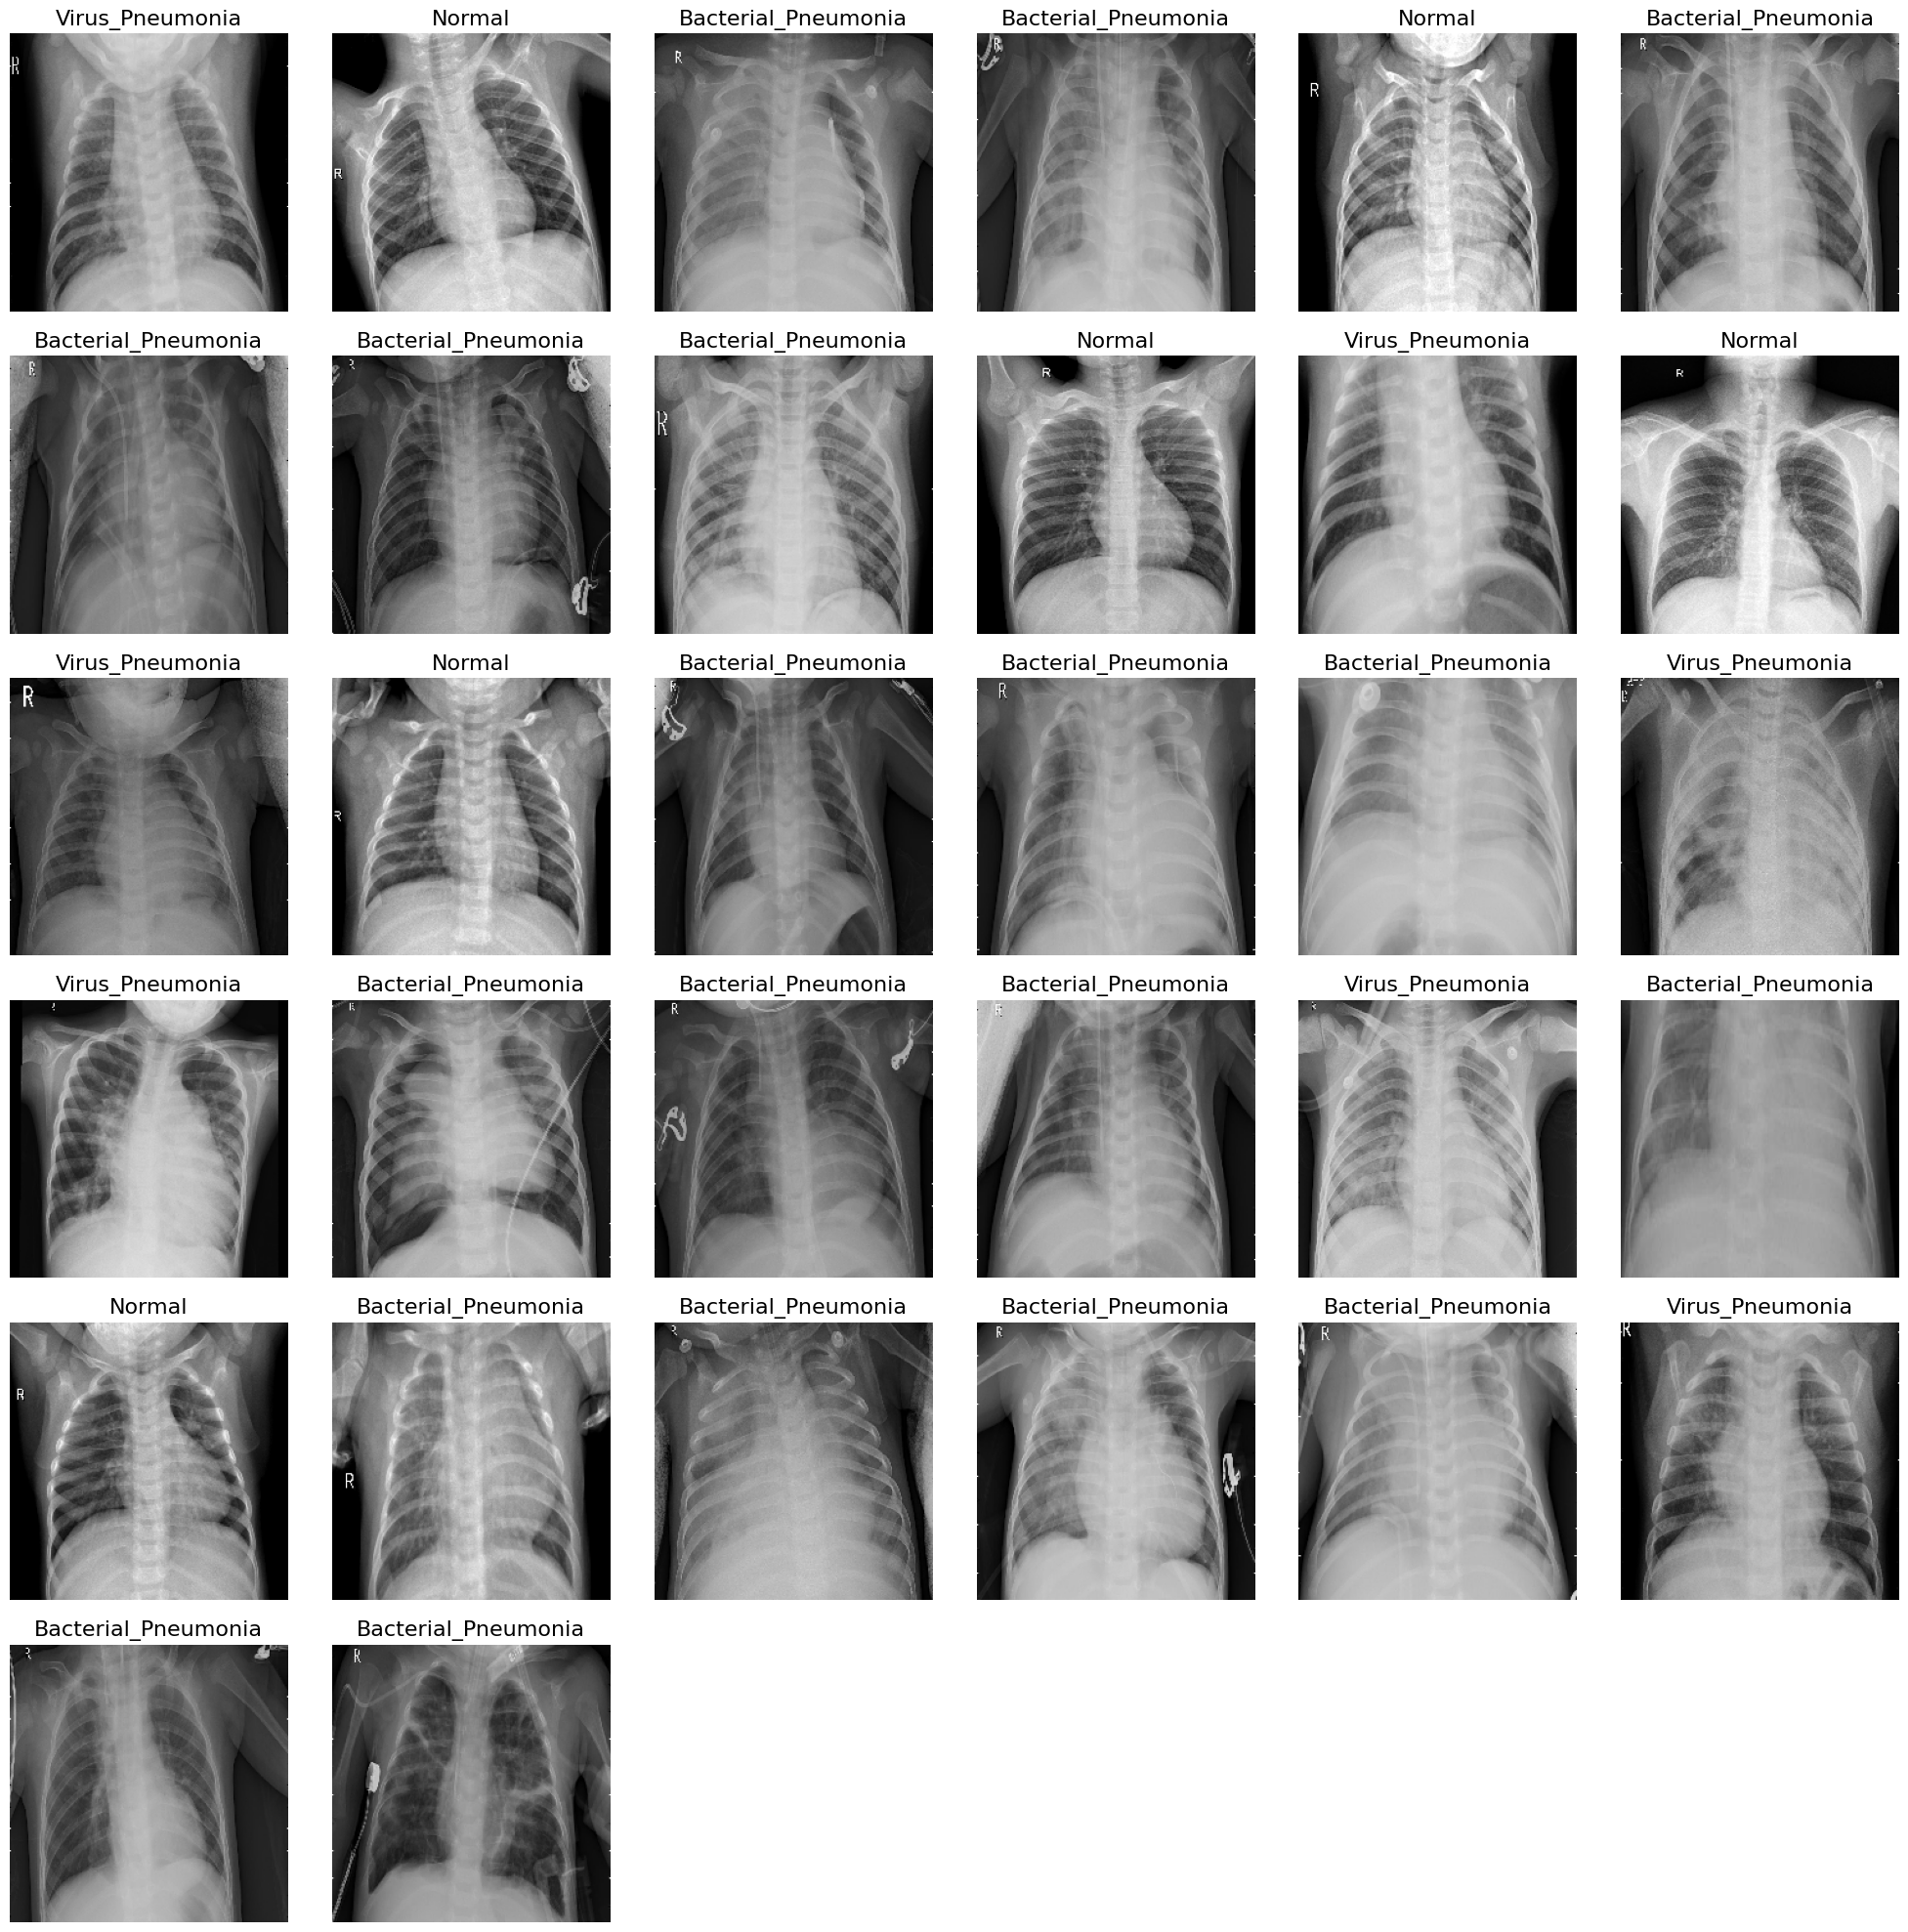

In [67]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [69]:
# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [70]:
# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred

In [71]:
# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred, fold):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (8, 8))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Pinks)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

In [72]:
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block

In [73]:
# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [48]:
# # create Model structure
# img_size = (224, 224)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)

# class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [49]:



def create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1],channels)

    class_counts = len(list(train_gen.class_indices.keys()))



    cnn_model = Sequential()
 # first conv block
    cnn_model.add(Conv2D(filters=int(filters1), kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())

    # second conv block
    cnn_model.add(Conv2D(filters=int(filters2), kernel_size=(3,3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())

    # third conv block
    cnn_model.add(Conv2D(filters=int(filters3), kernel_size=(3,3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())

    # flatten layer
    cnn_model.add(Flatten())

    # first dense block
    cnn_model.add(Dense(units=int(units1), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))

    # second dense block
    cnn_model.add(Dense(units=int(units2), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))

    # output layer
    cnn_model.add(Dense(class_counts, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

In [50]:
# cnn_model.summary() 

In [51]:
# def objective_function(solution):
#     filters1, filters2, filters3, units1, units2, learning_rate = solution
#     kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduce KFold for faster computation
    
#     accuracies = []
#     for train_index, val_index in kf.split(df):
#         train_df = df.iloc[train_index]
#         val_df = df.iloc[val_index]
        
#         train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
#                                                color_mode='rgb', shuffle=True, batch_size=batch_size)
        
#         val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
#                                              color_mode='rgb', shuffle=True, batch_size=batch_size)

#         model = create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate)
        
#         history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)  # Reduce epochs for faster computation
        
#         val_loss, val_acc = model.evaluate(val_gen, verbose=0)
#         accuracies.append(val_acc)
    
#     return -np.mean(accuracies) 

In [52]:
# #difne the parameter for zoopt

# dim = Dimension(
#     6, 
#     [
#         [16, 64],
#         [32, 128],
#         [64, 256],
#         [64, 512],
#         [32, 256],
#         [1e-5, 1e-3]
#     ],
#     [False, False, False, False, False, True]
# )

In [53]:
# #difine the objective
# obj = Objective(objective_function, dim)

# #optimization parameter
# param = Parameter(budget= 20)

# #peformance optim..
# solution = Opt.min(obj, param)
# print(solution)

# #get best sol..
# best_hyperparams = solution.get_x()

# print(f"Best hyperparameters: {best_hyperparams}")



# best_model = create_cnn_model(*best_hyperparams)

# history = best_model.fit(train_gen, validation_data= valid_gen, epoch= 20, verbose = 1)
# model_performance(history, 20)
# model_evaluation(best_model)

Found 3904 validated image filenames belonging to 3 classes.
Found 1952 validated image filenames belonging to 3 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mis

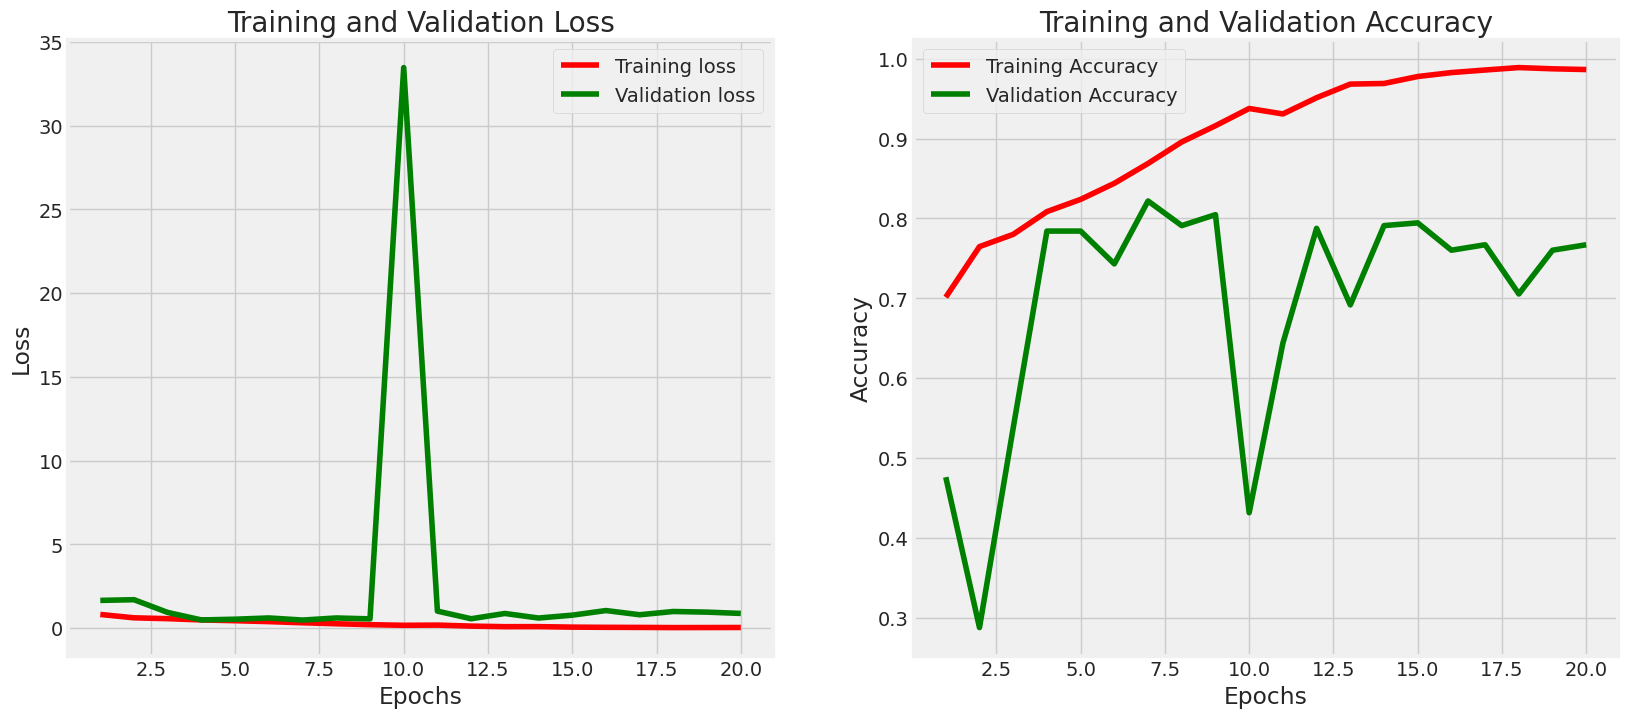

10/10 [==============================] - 2s 145ms/step - loss: 1.0682 - accuracy: 0.7440
Train Loss:  0.09925270825624466
Train Accuracy:  0.9626256823539734
--------------------
Validation Loss:  0.8817649483680725
Validation Accuracy:  0.767123281955719
--------------------
Test Loss:  1.0682092905044556
Test Accuracy:  0.744027316570282


In [55]:

# Define the objective function
def objective_function(solution):
    filters1, filters2, filters3, units1, units2, learning_rate = solution.get_x()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduce KFold for faster computation
    
    accuracies = []
    for train_index, val_index in kf.split(df):
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)
        
        val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

        model = create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate)
        
        history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)  # Reduce epochs for faster computation
        
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        accuracies.append(val_acc)
    
    return -np.mean(accuracies) 

# Define the parameter space for ZOOpt
dim = Dimension(
    6, 
    [
        [16, 64],
        [32, 128],
        [64, 256],
        [64, 512],
        [32, 256],
        [0.1, 1e-3]
    ],
    [False, False, False, False, False, True]
)

# Define the objective for ZOOpt
obj = Objective(objective_function, dim)

# Optimization parameters
param = Parameter(budget=20)

# Perform optimization
solution = Opt.min(obj, param)

# Get the best hyperparameters
best_hyperparams = solution.get_x()

print(f"Best hyperparameters: {best_hyperparams}")

# Create and train the best model
best_model = create_cnn_model(*best_hyperparams)

history = best_model.fit(train_gen, validation_data=valid_gen, epochs=20, verbose=1)

# Evaluate the model performance
model_performance(history, 20)
model_evaluation(best_model)

In [ ]:
# optimizer = Adam(learning_rate = learning_rate)

In [ ]:
# cnn_model.compile(optimizer=optimizer, loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
# # train the model
# epochs = 30   # number of all epochs in training

# history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.6154 - loss: 0.9379 - val_accuracy: 0.4315 - val_loss: 2.0339
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.7343 - loss: 0.6462 - val_accuracy: 0.4247 - val_loss: 1.4555
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.7622 - loss: 0.5957 - val_accuracy: 0.4110 - val_loss: 1.4698
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.7766 - loss: 0.5397 - val_accuracy: 0.6575 - val_loss: 0.8321
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.7988 - loss: 0.4813 - val_accuracy: 0.8151 - val_loss: 0.4797
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - accuracy: 0.7990 - loss: 0.4832 - val_accuracy: 0.8014 - val_loss: 0.4885
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.8191 - loss: 0.4527 - val_accuracy: 0.8048 - val_loss: 0.4506
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - accuracy: 0.8328 - loss: 0

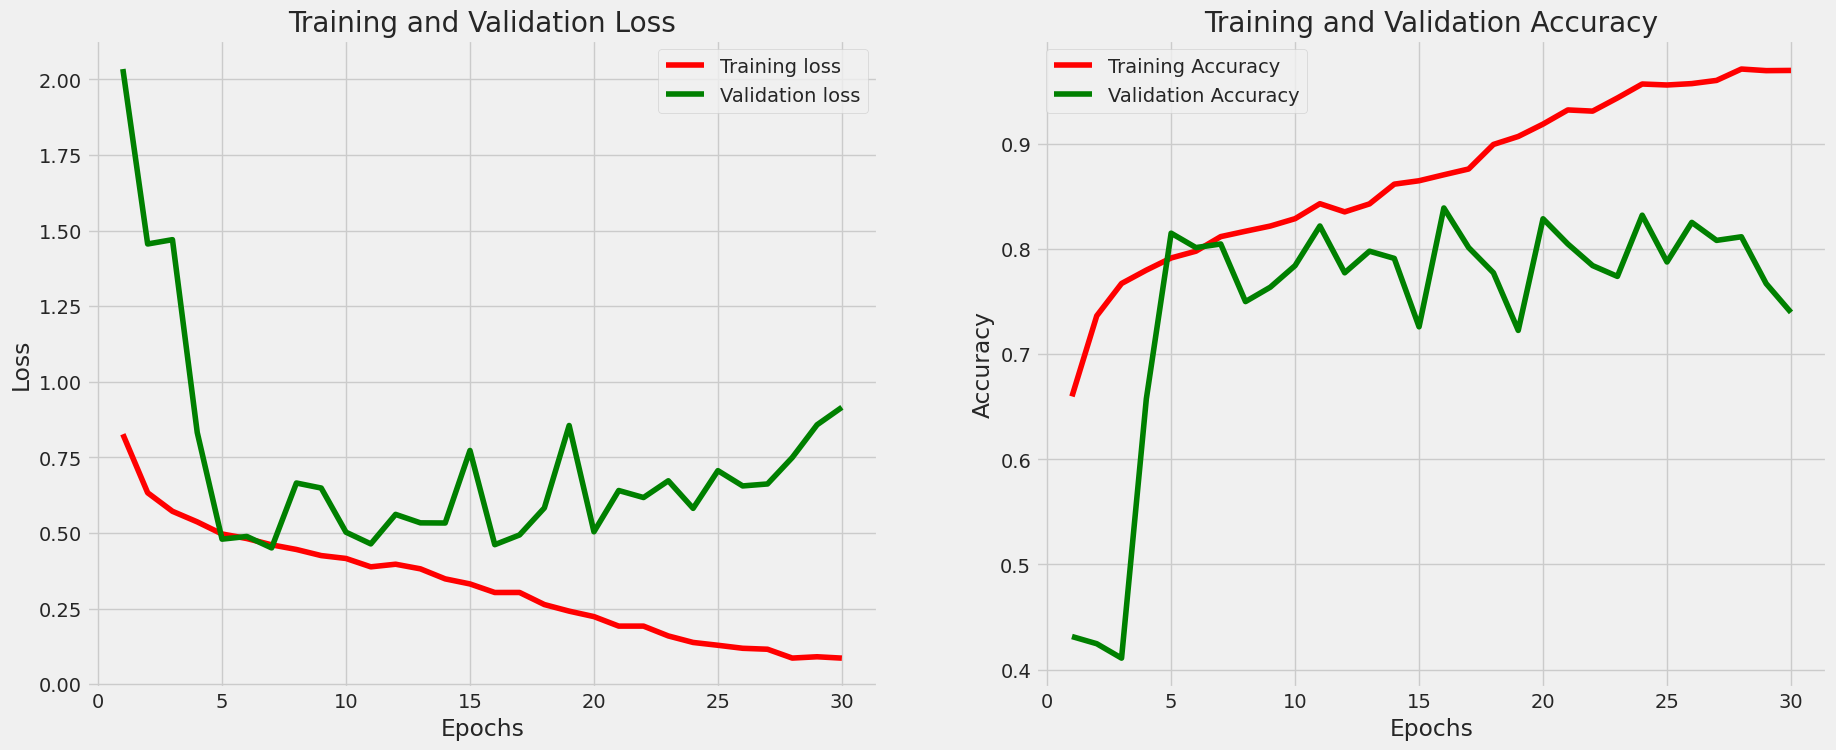

In [ ]:
# Display model performance
model_performance(history, epochs)

In [ ]:
# Model evaluation
model_evaluation(cnn_model)

165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9102 - loss: 0.2534
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7459 - loss: 0.9234
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7439 - loss: 0.8035
Train Loss:  0.25374123454093933
Train Accuracy:  0.9104534387588501
--------------------
Validation Loss:  0.9154576063156128
Validation Accuracy:  0.7397260069847107
--------------------
Test Loss:  0.7667286992073059
Test Accuracy:  0.7576791644096375


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


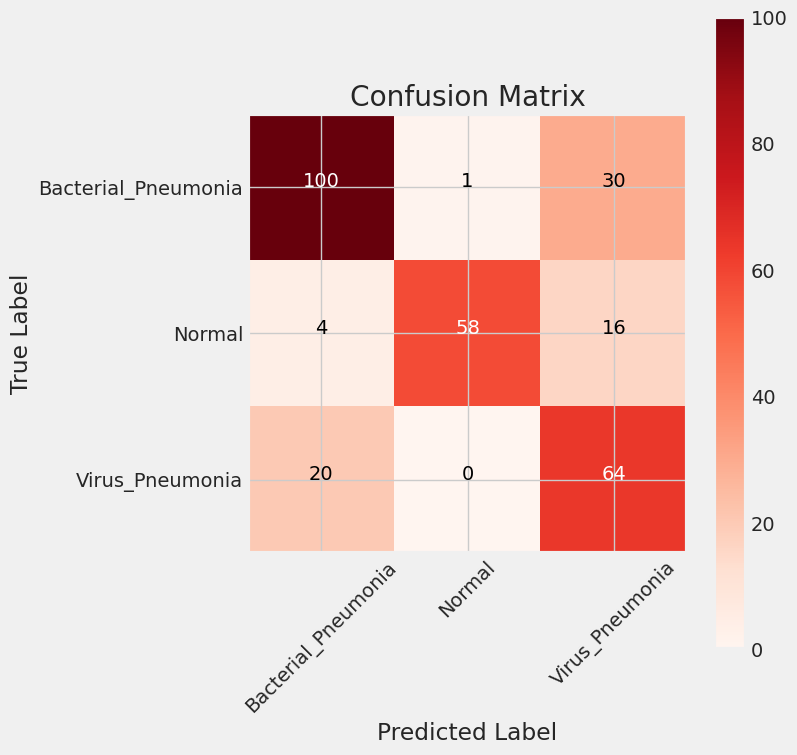

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       131
           1       0.98      0.74      0.85        78
           2       0.58      0.76      0.66        84

    accuracy                           0.76       293
   macro avg       0.79      0.76      0.76       293
weighted avg       0.79      0.76      0.77       293



In [ ]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred, fold + 1)

# #accuracy
# accuracy = accuracy_score(test_gen.classes, y_pred)
# print(f"Accuracy for fold {fold + 1}: {accuracy: .4f}")


#Recall
print(classification_report(test_gen.classes, y_pred))

In [ ]:
model_path = 'chest-xray.h5'

In [ ]:
cnn_model.save(model_path)